In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import re

PATH_perkin = r'.\PerkinElmer\zoom_edge_resolution student 12.csv'
PATH_Cary = r'.\Cary\GaAs.csv'
h = 6.626e-34
c = 299_792_458
e_v = 1.602e-19

In [2]:
class MEASUREMENT:
    def table(self):
        print(pd.DataFrame.from_dict(self.data, orient='columns'))
    def __call__(self, Bounds=('-inf', 'inf')):
        indices = self.closest_index(Bounds)
        interval = slice(*indices)
        plt.plot(self.data['x'][interval]*1e9, self.data['y'][interval], color='black')
        plt.xlabel(r'Våglängd $\lambda$ [nm]')
        plt.ylabel(r'Transmission $T$ [%]')
        plt.show()
    def closest_index(self, Bounds, x=None):
        index_b = []
        if x is None:
            x = self.data['x']
        for Bound in Bounds:
            if Bound=='-inf':
                index_b.append(0)
            elif Bound=='inf':
                index_b.append(len(x))
            else:
                index_b.append(list(np.abs(Bound-x)).index(min(abs(Bound-x))))
        return index_b

class PERKIN(MEASUREMENT):
    def __init__(self, path):
        super().__init__()
        self.data = {'x': [], 'y': []}
        with open(path, 'r') as file:
            wv_pattern = r'^\d+'
            tr_pattern = r'\d+,\d+$'
            for i, line in [pair for pair in enumerate(file) if pair[0]>=6]:
                wv = int(re.search(wv_pattern, line).group())
                tr = float(re.search(tr_pattern, line).group().replace(',', '.'))
                self.data['x'].append(wv)
                self.data['y'].append(tr)
        self.data['x'], self.data['y'] = np.array(self.data['x'])[::-1]*1e-9, np.array(self.data['y'])[::-1]


class CARY(MEASUREMENT):
    def __init__(self,path):
        super().__init__()
        self.data = {'x': [], 'y': []}
        with open(path, 'r') as file:
            ev_pattern = r'^\d+.\d+'
            tr_pattern = r'\d+.\d+,$'
            for i, line in [pair for pair in enumerate(file) if pair[0]>=3]:
                ev_match = re.search(ev_pattern, line)
                tr_match = re.search(tr_pattern, line)
                if not ev_match is None or not tr_match is None:
                    ev = float(ev_match.group())
                    tr = float(tr_match.group()[:-1])
                    self.data['x'].append(ev)
                    self.data['y'].append(tr)
        self.data['x'], self.data['y'] = np.array(self.data['x'])[::-1], np.array(self.data['y'])[::-1]
        self.data['x'] = h*c/self.data['x']/e_v

def combined(Meas1: MEASUREMENT, Meas2: MEASUREMENT, contact: float=3000e-9) -> dict:
    Meas1_indices = Meas1.closest_index(('-inf', contact))
    Meas2_indices = Meas2.closest_index((contact, 'inf'))
    Meas1_slice = slice(*Meas1_indices)
    Meas2_slice = slice(*Meas2_indices)
    # print(Meas1_indices, Meas2_indices)
    return {
        'x': np.concatenate((Meas1.data['x'][Meas1_slice], Meas2.data['x'][Meas2_slice])),
        'y': np.concatenate((Meas1.data['y'][Meas1_slice], Meas2.data['y'][Meas2_slice]))
        }

def plot_combined(Meas1: MEASUREMENT, Meas2: MEASUREMENT, contact: float=3000e-9, show=True) -> None:
    data = combined(Meas1, Meas2, contact=contact)
    plt.plot(data['x']*1e9, data['y'], color='black')
    plt.xlabel(r'Våglängd $\lambda$ [nm]')
    plt.ylabel(r'Transmission $T$ [%]')
    plt.grid()
    if show:
        plt.show()

In [3]:
Cary = CARY(PATH_Cary)
Perkin = PERKIN(PATH_perkin)

In [40]:
idx = Cary.closest_index((8.7e-7, 9.0e-7))
indices = slice(*idx)
print(idx)
for i, y in enumerate(reversed([d for d in Cary.data['y'][indices]])):
    if y<=0.01:
        E_g_index = list(Cary.data['y']).index(y)
        break

[29140, 29402]
0.007377047092 0.007377047092


8.789763087144714e-07


C:\Users\Junior\AppData\Local\Temp\ipykernel_6516\3153833419.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[1].set_ylim([0, 45])


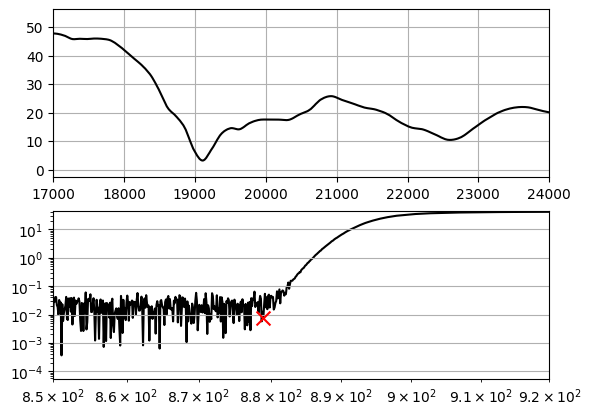

In [43]:
%matplotlib inline
data = combined(Cary, Perkin)
print(data['x'][E_g_index])
matplotlib.rcParams.update({'font.size':10})
fig, axs = plt.subplots(2,1)
axs[1].plot(data['x']*1e9, data['y'], color='black', zorder=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim([850, 920])
axs[1].set_ylim([0, 45])
axs[1].grid(zorder=0)
# axs[1].scatter(883.066, 0.155776, color='red', marker='x', s=100)
axs[1].scatter(data['x'][E_g_index]*1e9, data['y'][E_g_index], color='red', marker='x', s=100, zorder=2)
axs[0].plot(data['x']*1e9, data['y'], color='black')
# axs[0].set_xscale('log')
axs[0].set_xlim([1.7e4, 2.4e4])
# axs[0].set_xlim([4673, 8621])
# axs[0].set_ylim([39, 56])
axs[0].grid()
# axs[0].scatter(883.066, 0.155776, color='red', marker='x', s=100)
# plt.axvline(3000, color='red', linestyle='--')
# plt.yscale('log')
# plt.xlim([4673, 8621])
# plt.ylim([39, 56])
# plt.xlim([850, 920])
# plt.ylim([0, 45])
plt.savefig(r'.\Figurer\zooms3.png', dpi=300)
plt.show()

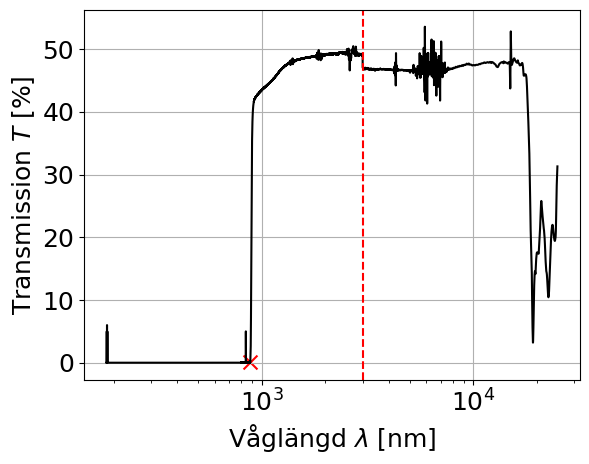

In [9]:
%matplotlib inline
matplotlib.rcParams.update({'font.size':18})
plt.plot(data['x']*1e9, data['y'], color='black')
plt.scatter(883.066, 0.155776, color='red', marker='x', s=100)
plt.axvline(3000, color='red', linestyle='--')
plt.grid()
plt.xscale('log')
plt.xlabel(r'Våglängd $\lambda$ [nm]')
plt.ylabel(r'Transmission $T$ [%]')
# plt.savefig(r'.\Figurer\Transmissionsspektrum.png', bbox_inches='tight', dpi=300)
plt.show()